# Some Required Imports and Functions

In [1]:

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer
from matplotlib import pyplot as plt
import pandas as pd
import gensim
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics
import seaborn as sns
from nltk.stem.porter import *
from sklearn.linear_model import LogisticRegression

# Some constants will be used to preprocess the datasets
stemmer = PorterStemmer()
stop = stopwords.words('english')


In [2]:
df_covid = pd.read_excel('comments/Covid.xlsx',index=False).dropna()

In [3]:
# Some Required Functions

import re
def remove_digits(string):
    return re.sub('[^a-zA-Z]', ' ', string )

def remove_special_chars(string):
    return re.sub(r'\s+', ' ', string)

# Return Accuracy, Precision, Recall, F-Score
def print_metrics(pred,y_test):
    acc= np.mean(pred == y_test)*100
    f_score= f1_score(y_test, pred,average='weighted')*100
    p = precision_score(y_test, pred,average='weighted')*100
    r = recall_score(y_test, pred,average='weighted',labels=np.unique(pred))*100
    print("Accuracy is",acc)
    print("Precision is",p)
    print("Recall is",r)
    print("F1-Score is",f_score)
    return acc, p, r, f_score

## Accuracy, Precision, Recall

# More Advanced Function that helps a lot in evaluating the algorithms on our datasets
def print_results(y_test,predicted,predicted_prob):
    classes = np.unique(y_test)
    accuracy = metrics.accuracy_score(y_test, predicted)
    auc = metrics.roc_auc_score(y_test, predicted_prob, 
                                multi_class="ovr")
    print("Accuracy:",  round(accuracy,2))
    print("Area Under The Curve:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    make_confusion_matrix(cf=cm,figsize=(8,5))

    
# https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
# Draws the confusion matrix in a very nice way
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Oranges',
                          title="Confusion Matrix"):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        


# MultinomialNB and SGD Classifier without removing stopwords using unigrams

Accuracy: 0.79
Area Under The Curve: 0.82
Detail:
              precision    recall  f1-score   support

          -1       0.79      0.98      0.88     53344
           0       0.83      0.26      0.40     13908
           1       0.69      0.08      0.14      4057

    accuracy                           0.79     71309
   macro avg       0.77      0.44      0.47     71309
weighted avg       0.79      0.79      0.74     71309



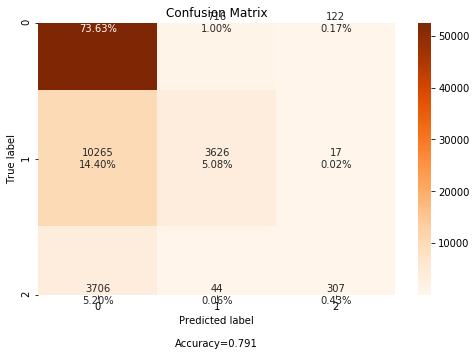

In [4]:
X = df_covid['comment']
Y = df_covid['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=15)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

clf_1 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,1),max_df=0.1, min_df= 0,strip_accents= 'unicode')),
                 ('NB_clf',MultinomialNB(alpha=0.1))])

clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

Accuracy: 0.78
Area Under The Curve: 0.82
Detail:
              precision    recall  f1-score   support

          -1       0.77      0.99      0.87     53344
           0       0.87      0.17      0.28     13908
           1       0.97      0.02      0.04      4057

    accuracy                           0.78     71309
   macro avg       0.87      0.39      0.40     71309
weighted avg       0.80      0.78      0.71     71309



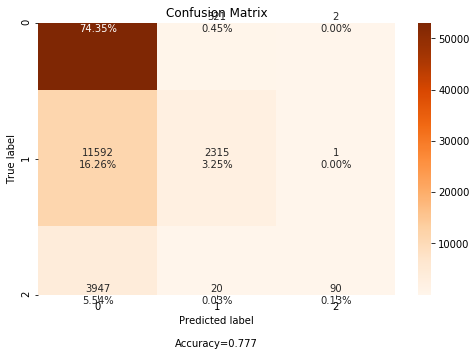

In [5]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,1),max_df=0.1, min_df= 0,strip_accents= 'unicode')),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1500))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
print_results(y_test,pred,pred_proba)

In [ ]:
## This cell was previously used to choose the best parameter

## --------------- GRID SEARCH FOR PARAMETER TUNING -----------------------

clf_1 = Pipeline([('tfidf', TfidfVectorizer()),
                 ('NB_clf',MultinomialNB())])


parameters = {'NB_clf__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], 
              'tfidf__max_df':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
              'tfidf__min_df':[0]}

grid_gearch = GridSearchCV(clf_1, parameters, n_jobs=-1)


grid_gearch = grid_gearch.fit(X_train, y_train)

print(grid_gearch.best_score_, grid_gearch.best_params_)


#Output I got for grid search: 
# 0.7946835229092032 {'NB_clf__alpha': 0.1, 'tfidf__max_df': 0.1, 'tfidf__min_df': 0}

# MultinomialNB and SGD Classifier without removing stopwords using Bigrams

Accuracy: 0.8
Area Under The Curve: 0.79
Detail:
              precision    recall  f1-score   support

          -1       0.80      0.99      0.88     53344
           0       0.86      0.30      0.44     13908
           1       0.77      0.05      0.10      4057

    accuracy                           0.80     71309
   macro avg       0.81      0.45      0.48     71309
weighted avg       0.81      0.80      0.75     71309



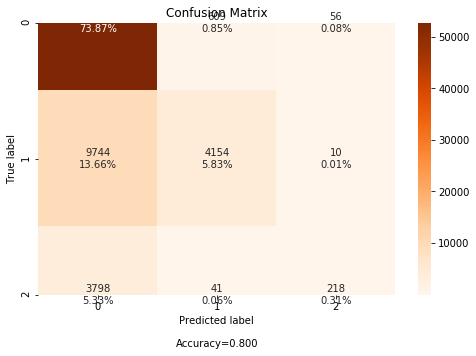

In [10]:
X = df_covid['comment']
Y = df_covid['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=15)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

clf_1 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2),max_df=0.1, min_df= 0,strip_accents= 'unicode')),
                 ('NB_clf',MultinomialNB(alpha=0.1))])

clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

Accuracy: 0.76
Area Under The Curve: 0.79
Detail:
              precision    recall  f1-score   support

          -1       0.76      1.00      0.86     53344
           0       0.93      0.08      0.15     13908
           1       1.00      0.00      0.01      4057

    accuracy                           0.76     71309
   macro avg       0.90      0.36      0.34     71309
weighted avg       0.81      0.76      0.68     71309



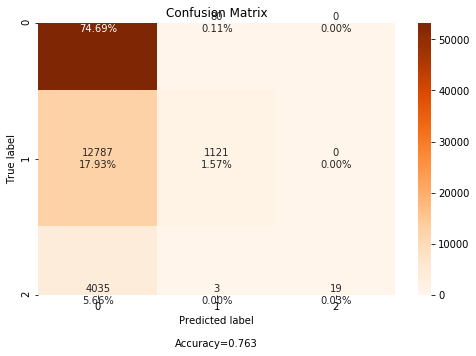

In [11]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2),max_df=0.1, min_df= 0,strip_accents= 'unicode')),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1500))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
print_results(y_test,pred,pred_proba)

# MultinomialNB and SGD Classifier without removing stopwords using Trigams

Accuracy: 0.79
Area Under The Curve: 0.75
Detail:
              precision    recall  f1-score   support

          -1       0.79      0.99      0.88     53344
           0       0.89      0.24      0.38     13908
           1       0.81      0.04      0.07      4057

    accuracy                           0.79     71309
   macro avg       0.83      0.42      0.44     71309
weighted avg       0.81      0.79      0.73     71309



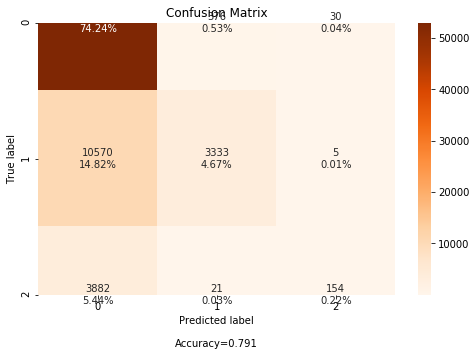

In [12]:
X = df_covid['comment']
Y = df_covid['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=15)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

clf_1 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3),max_df=0.1, min_df= 0,strip_accents= 'unicode')),
                 ('NB_clf',MultinomialNB(alpha=0.1))])

clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)

Accuracy: 0.76
Area Under The Curve: 0.75
Detail:
              precision    recall  f1-score   support

          -1       0.75      1.00      0.86     53344
           0       0.93      0.04      0.08     13908
           1       1.00      0.00      0.01      4057

    accuracy                           0.76     71309
   macro avg       0.89      0.35      0.31     71309
weighted avg       0.80      0.76      0.66     71309



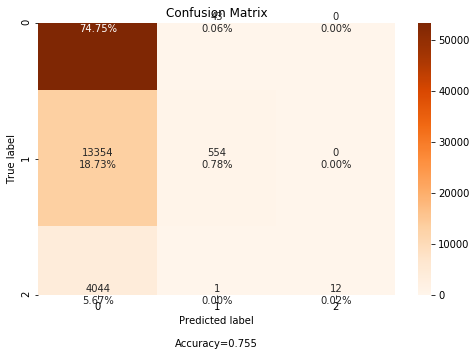

In [13]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,3),max_df=0.1, min_df=0,strip_accents= 'unicode')),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1500))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
print_results(y_test,pred,pred_proba)

# MultinomialNB and SGD Classifier with removing stopwords using bigrams

Accuracy: 0.8
Area Under The Curve: 0.79
Detail:
              precision    recall  f1-score   support

          -1       0.80      0.99      0.88     53344
           0       0.87      0.30      0.44     13908
           1       0.80      0.05      0.10      4057

    accuracy                           0.80     71309
   macro avg       0.82      0.45      0.48     71309
weighted avg       0.81      0.80      0.75     71309



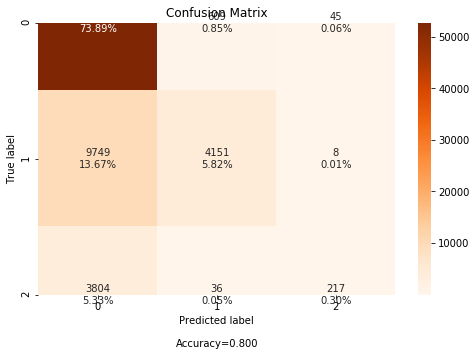

In [7]:
df_covid['comment_removed_stopwords'] =  df_covid['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

X = df_covid['comment_removed_stopwords']
Y = df_covid['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=15)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

clf_1 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2),max_df=0.1, min_df= 0,strip_accents= 'unicode')),
                 ('NB_clf',MultinomialNB(alpha=0.1))])

clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
pred_proba = clf_1.predict_proba(X_test)
print_results(y_test,pred,pred_proba)


Accuracy: 0.76
Area Under The Curve: 0.79
Detail:
              precision    recall  f1-score   support

          -1       0.76      1.00      0.86     53344
           0       0.92      0.09      0.16     13908
           1       1.00      0.01      0.01      4057

    accuracy                           0.76     71309
   macro avg       0.90      0.36      0.35     71309
weighted avg       0.81      0.76      0.68     71309



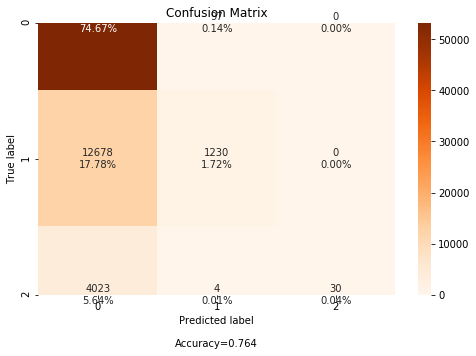

In [8]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2),max_df=0.1, min_df=0,strip_accents= 'unicode')),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1500))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
print_results(y_test,pred,pred_proba)

# MultinomialNB, SGD Classifier, Logistic Regression Classifier with removing stopwords and using  stemming with bigrams

In [8]:
df_covid['comments'] = df_covid['comment'].apply(remove_digits)
df_covid['comments'] = df_covid['comments'].apply(remove_special_chars)
df_covid['comments'] = df_covid['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_covid['comments'] = df_covid['comments'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

X = df_covid['comments']
Y = df_covid['stance']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=15)
X_train = X_train.reset_index(drop=True).tolist()
X_test  = X_test.reset_index(drop=True).tolist()
y_train = y_train.reset_index(drop=True).tolist()
y_test  = y_test.reset_index(drop=True).tolist()

clf_1 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2),max_df=0.1, min_df= 0,strip_accents= 'unicode')),
                 ('NB_clf',MultinomialNB(alpha=0.1))])

clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
print_metrics(pred,y_test)

Accuracy is 80.02215709097028
Precision is 80.90545131221806
Recall is 80.02215709097028
F1-Score is 75.15743363910045


(80.02215709097028, 80.90545131221806, 80.02215709097028, 75.15743363910045)

In [9]:
clf_1 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2),max_df=0.1, min_df= 0,strip_accents= 'unicode')),
                 ('LOR_clf',LogisticRegression())])

clf_1 = clf_1.fit(X_train, y_train)
pred = clf_1.predict(X_test)
print_metrics(pred,y_test)

c:\users\yusuf\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy is 81.9630060721648
Precision is 81.29801941983229
Recall is 81.9630060721648
F1-Score is 79.26999362819976


(81.9630060721648, 81.29801941983229, 81.9630060721648, 79.26999362819976)

In [10]:
clf_2 = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2),max_df=0.1, min_df=0,strip_accents= 'unicode')),
                      ('clf-SGD', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001,max_iter=1500))])

clf_2 = clf_2.fit(X=X_train,y=y_train)
pred = clf_2.predict(X_test)
print_metrics(pred,y_test)

Accuracy is 76.50226479126057
Precision is 80.87378978715091
Recall is 76.50226479126057
F1-Score is 67.95755925156351


(76.50226479126057, 80.87378978715091, 76.50226479126057, 67.95755925156351)